# UC Berkeley Math 228B, Spring 2022: Problem Set 1




## Problem 1a
The 9-point Laplacian is written 

\begin{align*}
    \nabla_9^2u_{i,j} &= \frac{1}{6h^2}\big[20u_{i,j} - 4u_{i-1,j} - 4u_{i+1,j} - 4u_{i,j-1}
    \\
    & - 4u_{i,j+1} - 1u_{i+1,j+1} - 1u_{i+1,j-1} - 1u_{i-1,j+1} - 1u_{i-1,j-1}\big]
\end{align*}

$$ \frac{1}{1} $$

\begin{align*}\label{eq:9ptL}
    \nabla_9^2u_{i,j} = & \frac{1}{6h^2 }[20u_{i,j} -  4u_{i-1,j} -   4u_{i+1,j} -  4u_{i,j-1} - 4u_{i,j+1}
    \\
                        & - 1u_{i+1,j+1} - 1u_{i+1,j-1} - 1u_{i-1,j+1} - 1u_{i-1,j-1}], \numberthis{}
    \\
    \nabla_5^2u_{i,j} = & \frac{1}{h^2}[4u_{i,j} - u_{i-1,j} - u_{i+1,j} - u_{i,j-1} - u_{i,j+1}]
\end{align*}

## Problem 1b



In [ ]:
using SparseArrays, Plots
using LaTeXStrings
Plots.pyplot()

: 

In [60]:
"""
A, b, x, y = Poisson9(n, f, g)

Assemble linear system Au = b for Poisson's equation using finite differences.
Grid size (n+1) x (n+1), right hand side function f(x,y), Dirichlet boundary
conditions g(x,y).

Based on function 'assemblePoisson' from course page,
UC Berkeley Math 228B, Per-Olof Persson <persson@berkeley.edu>
"""
function Poisson9(n, f, g)
    h = 1.0 / n
    N = (n+1)^2
    x = h * (0:n)
    y = x

    umap = reshape(1:N, n+1, n+1)     # Index mapping from 2D grid to vector
    A = Tuple{Int64,Int64,Float64}[]  # Array of matrix elements (row,col,value)
    b = zeros(N)

    # Main loop, insert stencil in matrix for each node point
    for j = 1:n+1
        for i = 1:n+1
            row = umap[i,j]
            if i == 1 || i == n+1 || j == 1 || j == n+1
                # Dirichlet boundary condition, u = g
                push!(A, (row, row, 1.0))
                b[row] = g(x[i],y[j])
            else
                # Interior nodes, 9-point stencil
                push!(A, (row, row, 20.0))

                push!(A, (row, umap[i+1,j], -4.0))
                push!(A, (row, umap[i-1,j], -4.0))
                push!(A, (row, umap[i,j+1], -4.0))
                push!(A, (row, umap[i,j-1], -4.0))

                push!(A, (row, umap[i+1,j-1], -1.0))
                push!(A, (row, umap[i-1,j+1], -1.0))
                push!(A, (row, umap[i+1,j+1], -1.0))
                push!(A, (row, umap[i-1,j-1], -1.0))

                # 5-point stencil for nabla f_ij
                d5f = 4 * f(x[i], y[j])
                d5f -= f(x[i-1], y[j])
                d5f -= f(x[i+1], y[j])
                d5f -= f(x[i], y[j-1])
                d5f -= f(x[i], y[j+1])

                # rhs of linear equations
                b[row] = (f(x[i], y[j]) - d5f / 12) * h^2 * 6
            end
        end
    end

    # Create CSC sparse matrix from matrix elements
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), N, N)

    return A, b, x, y
end

Poisson9

In [61]:
"""
    A, b, x, y = assemblePoisson(n, f, g)

Assemble linear system Au = b for Poisson's equation using finite differences.
Grid size (n+1) x (n+1), right hand side function f(x,y), Dirichlet boundary
conditions g(x,y).
"""
function Poisson5(n, f, g)
    h = 1.0 / n
    N = (n+1)^2
    x = h * (0:n)
    y = x

    umap = reshape(1:N, n+1, n+1)     # Index mapping from 2D grid to vector
    A = Tuple{Int64,Int64,Float64}[]  # Array of matrix elements (row,col,value)
    b = zeros(N)

    # Main loop, insert stencil in matrix for each node point
    for j = 1:n+1
        for i = 1:n+1
            row = umap[i,j]
            if i == 1 || i == n+1 || j == 1 || j == n+1
                # Dirichlet boundary condition, u = g
                push!(A, (row, row, 1.0))
                b[row] = g(x[i],y[j])
            else
                # Interior nodes, 5-point stencil
                push!(A, (row, row, 4.0))
                push!(A, (row, umap[i+1,j], -1.0))
                push!(A, (row, umap[i-1,j], -1.0))
                push!(A, (row, umap[i,j+1], -1.0))
                push!(A, (row, umap[i,j-1], -1.0))
                b[row] = f(x[i], y[j])  * h^2
            end
        end
    end

    # Create CSC sparse matrix from matrix elements
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), N, N)

    return A, b, x, y
end

Poisson5

In [62]:
"""
error = testPoisson(n=20)

Poisson test problem:
  - Prescribe exact solution uexact
  - set boundary conditions g = uexact and set RHS f = -Laplace(uexact)

Solves and plots solution on a (n+1) x (n+1) grid.
Returns error in max-norm.
"""
function testPoisson(n=40, Poisson=Poisson9)
    uexact(x,y) = exp(-(4(x - 0.3)^2 + 9(y - 0.6)^2))
    f(x,y) = uexact(x,y) * (26 - (18y - 10.8)^2 - (8x - 2.4)^2)
    A, b, x, y = Poisson(n, f, uexact)

    # Solve + reshape solution into grid array
    u = reshape(A \ b, n+1, n+1)

    # Compute error in max-norm
    u0 = uexact.(x, y')
    error = maximum(abs.(u - u0))
    return error
end

testPoisson

In [88]:
"""
power = gridRefinement(n)

Finds error in max-norm for different grid-sizes ns
Plots log(error) as function of step-length
Performs regression to determine power law
returns power
"""
function gridRefinement(n)
    h = log10.(1 ./ n)
    errs5 = zeros(length(n))
    errs9 = zeros(length(n))
    for i = 1:length(n)
        errs9[i] = log10(testPoisson(n[i]))
        errs5[i] = log10(testPoisson(n[i], Poisson5))
    end
    
    # determine slope of decreasing error using linear regression
    exclude = 2
    X = zeros(length(n) - exclude, 2)
    X[:, 1] .= h[exclude+1:end]
    X[:, 2] .= 1.
    slope9 = (X \ errs9[exclude+1:end])[1]
    slope5 = (X \ errs5[exclude+1:end])[1]

    p = plot(h, errs9, linewidth=2, markershapes=:cross, markersize=8, label="9-point. Slope = $(round(slope9, digits=3))")
    plot!(h, errs5, linewidth=2, markershapes=:cross, markersize=8, label="5-point. Slope = $(round(slope5, digits=3))")
    plot!(title="Error as function of step-size h", xlabel=L"\log_{10}(h)", ylabel=L"\log_{10}(Error)", legend=:bottomright)
    savefig("gridRefinement.pdf")
end

gridRefinement

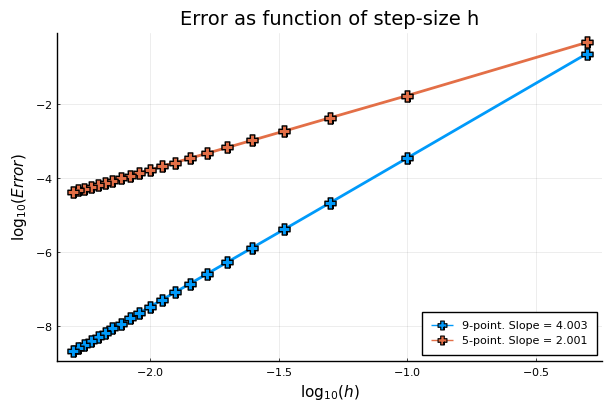

In [90]:
gridRefinement(collect([2; 10:10:200]))

Can I make nice \latex here?
\begin{align}
    \sum_{i=0}^ni &= \frac{n(n+1)}{2} 
    \\
    a &= 4
\end{align}

In [73]:

function buildA(L, B, H, n)
    # computational domain tools
    h = 1.0 / n
    N = (n+1)^2
    xi = h * (0:n)
    eta = xi

    D = (L - B) / 2
    A = sqrt(D^2 - H^2)

    # horrible expressions
    gamma(i, j) = B/2 + A * eta[j]
    x(i, j) = xi[i] * gamma(i, j)
    y(i, j) = H * eta[j]

    Jac(i, j) = H * gamma(i, j)
    a(i, j) = A^2 * xi[i]^2 + H^2
    b(i, j) = A * xi[i] * gamma(i, j)
    c(i, j) = gamma(i, j)^2
    d(i, j) = 0
    e(i, j) = 2 * A^2 * xi[i]

    umap = reshape(1:N, n+1, n+1)     # Index mapping from 2D grid to vector
    Amat = Tuple{Int64,Int64,Float64}[]  # Array of matrix elements (row,col,value)
    bvec = zeros(N)
    
    # creat meshes for x and y
    X = [(x(i, j), y(i, j)) for i=1:n+1, j=1:n+1]
    xvec = map(x->x[1], X)
    yvec = map(x->x[2], X)

    # Main loop, insert stencil in matrix for each node point
    for j = 1:n+1
        for i = 1:n+1
            row = umap[i,j]
            if j == 1 || i == n+1
                # Dirichlet boundary condition, u = 0 at P1P2, P2P3
                push!(Amat, (row, row, 1.0))
                bvec[row] = 0

            elseif i == 1
                # von Neumann condition, u'=0 at P1P4 
                # normal vector same in both physical and computational domain
                # push!(Amat, (row, row, 1.0))
                push!(Amat, (row, umap[i,j], -1.5))
                push!(Amat, (row, umap[i+1,j], 2.0))
                push!(Amat, (row, umap[i+2,j], -0.5))
                bvec[row] = 0
                
            elseif j == n+1
                # von Neumann condition, u'=0 at P3P4
                nxi = h / 2 * A * xi[i] / Jac(i, j)
                neta = h / H

                push!(Amat, (row, umap[i,j], -1.5 * neta))
                push!(Amat, (row, umap[i,j-1], 2.0 * neta))
                push!(Amat, (row, umap[i,j-2], -0.5 * neta))
                
                push!(Amat, (row, umap[i+1,j], 1 * nxi))
                push!(Amat, (row, umap[i-1,j], -1 * nxi))
                bvec[row] = 0

            else
                # Interior nodes
                push!(Amat, (row, row, -2 * (a(i, j) + c(i, j))  ) )

                push!(Amat, (row, umap[i+1,j], a(i, j) + e(i, j) * h / 2))
                push!(Amat, (row, umap[i-1,j], a(i, j) - e(i, j) * h / 2))
                push!(Amat, (row, umap[i,j+1], c(i, j)))
                push!(Amat, (row, umap[i,j-1], c(i, j)))

                push!(Amat, (row, umap[i+1,j+1], -b(i, j) / 2))
                push!(Amat, (row, umap[i-1,j-1], -b(i, j) / 2))
                push!(Amat, (row, umap[i+1,j-1], b(i, j) / 2))
                push!(Amat, (row, umap[i-1,j+1], b(i, j) / 2))

                # rhs of linear equations
                bvec[row] = -Jac(i, j)^2 * h^2
            end
        end
    end

    # Create CSC sparse matrix from matrix elements
    Amat = sparse((x->x[1]).(Amat), (x->x[2]).(Amat), (x->x[3]).(Amat), N, N)

    return Amat, bvec, xvec, yvec
end


buildA (generic function with 1 method)

In [66]:
function channelflow(L, B, H, n)
    A, b, xvec, yvec = buildA(L, B, H, n)
    u = reshape(A \ b, n+1, n+1)
    
    Q = u[1, 1] + u[1, end] + u[end, 1] + u[end, end]
    Q += 2 * (sum(u[1, :]) + sum(u[end, :]) + sum(u[:, 1]) + sum(u[:, end]))
    Q += 4 * sum(u[2:end-1, 2:end-1])
    Q /= 4 * n^2
    return Q, xvec, yvec, u
end

channelflow (generic function with 1 method)

In [83]:
function plotflow(x, y, u, text)
    # Plotting
    p = plot(title=text, xlabel="x", ylabel="y", layout=2, size=(1200, 600))
    plot!(p[1], x, y, u, c=:viridis, st=:contour, fill=false, levels=12, contour_labels=true)
    plot!(p[1], x, y, label=false, color="black", lw=1, alpha=0.2)
    plot!(p[1], x', y', label=false, color="black", lw=1, alpha=0.2)
    plot!(p[2], x, y, u, c=:viridis, st=:contour, fill=true, levels=201)
    
end


plotflow (generic function with 1 method)

0.08062988790318423


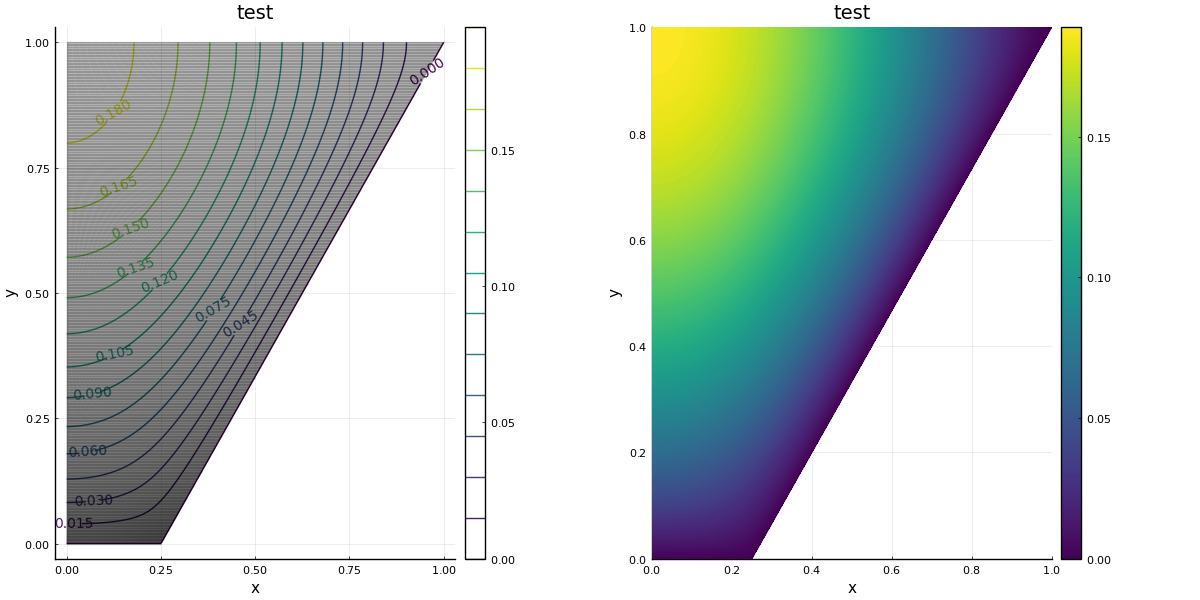

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [84]:
n = 320

L = 3.
B = 0.5
H = 1

Q, x, y, u = channelflow(L, B, H, n)
println(Q)
plotflow(x, y, u, "test")

In [215]:
function channelConvergence(Bs, start_n, n_cnt, excl)
    L = 3.
    H = 1.
    reference = start_n * 2^n_cnt
    plots = []
    for B in Bs
        trueQ, _, _, _ = channelflow(L, B, H, reference)
        hs = zeros(n_cnt)
        errs = zeros(n_cnt)
        n = start_n
        for i in 1:n_cnt
            Q, _, _, _ = channelflow(L, B, H, n)
            errs[i] = log10(abs(Q - trueQ) / trueQ)
            hs[i] = log10(1 / n)
            n *= 2
        end
        X = zeros(length(hs) - excl, 2)
        X[:, 1] .= hs[excl+1:end]
        X[:, 2] .= 1
        slope, inter = (X \ errs[excl+1:end])
        p = plot(hs, errs, title="Relative error in "*L"\hat{Q}"*" for B = $(B)", st=:scatter, markershapes=:cross, markersize=8, label="")
        plot!(hs, inter .+ slope .* hs, linewidth=2, label="Slope = $(round(slope, digits=3))")
        push!(plots, p)
    end
    l = @layout [a; b; c]
    plot(plots..., layout=l, size=(600, 800), xlabel=L"\log_{10}(h)", ylabel=L"\log_{10}(Error)", legend=:bottomright)
    savefig("figs/convergence.pdf")
end

channelConvergence (generic function with 2 methods)

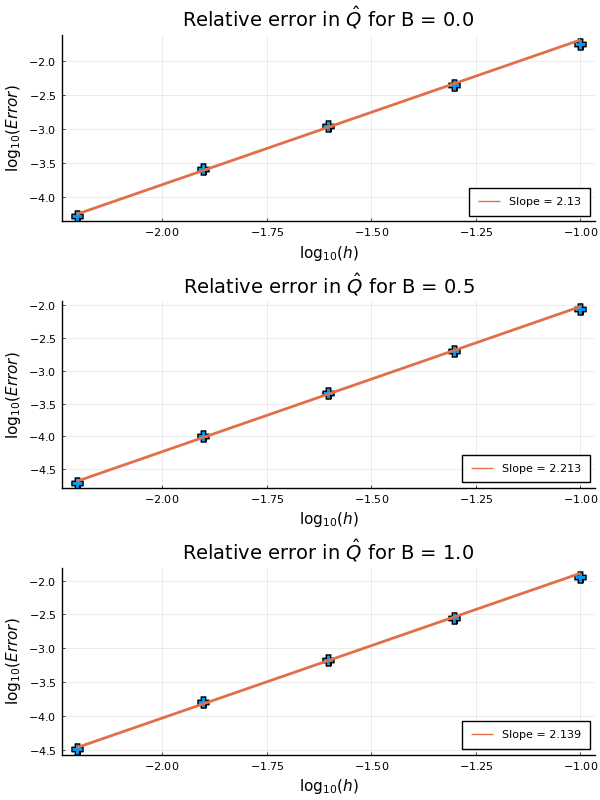

In [217]:
channelConvergence([0, 0.5, 1], 10, 5, 1) # problem 2d
